# Demand Forecasting 

Chalermchai Kamlungdach

Question : To predict 3 months of item-level sales data at different store locations.

# Exploratory Data Analysis 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator
import seaborn as sns

In [3]:
# load training data
data_df = pd.read_csv('demand-forecasting/train.csv')

#### Preview dataset

In [3]:
# preview dataset
print("=========== Dataset ===========")
print(data_df)

print("\n\n=========== Check datatype ===========")
print(data_df.dtypes)

=========== Dataset ===========
              date  store  item  sales
0       2013-01-01      1     1     13
1       2013-01-02      1     1     11
2       2013-01-03      1     1     14
3       2013-01-04      1     1     13
4       2013-01-05      1     1     10
...            ...    ...   ...    ...
912995  2017-12-27     10    50     63
912996  2017-12-28     10    50     59
912997  2017-12-29     10    50     74
912998  2017-12-30     10    50     62
912999  2017-12-31     10    50     82

[913000 rows x 4 columns]


=========== Check datatype ===========
date     object
store     int64
item      int64
sales     int64
dtype: object


#### Explore variable

In [5]:
print("=========== Number of stores ===========")
print(data_df[["store"]].nunique())

print("\n=========== Number of items ===========")
print(data_df[["item"]].nunique())

print("\n=========== Number of items in each store ===========")
print(data_df.groupby(["store"])["item"].nunique())

print("\n=========== Item List   ===========")
print(str(data_df["item"].unique()))
print("\n=========== Store List   ===========")
print(str(data_df["store"].unique()))

print("\n=========== Check for missing values ===========")
print(data_df.isnull().sum())

print("\n=========== Summary statistics ===========")
print(data_df.describe())
print(f"Min date : {data_df['date'].min()}")
print(f"Max date : {data_df['date'].max()}")


=========== Number of stores ===========
store    10
dtype: int64

=========== Number of items ===========
item    50
dtype: int64

=========== Number of items in each store ===========
store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

=========== Item List   ===========
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]

=========== Store List   ===========
[ 1  2  3  4  5  6  7  8  9 10]

=========== Check for missing values ===========
date     0
store    0
item     0
sales    0
dtype: int64

=========== Summary statistics ===========
               store           item          sales
count  913000.000000  913000.000000  913000.000000
mean        5.500000      25.500000      52.250287
std         2.872283      14.430878      28.801144
min         1.000000       1.000000       0.000000
25%         3.000000      

#### From preview and explore dataset we can see that
a) The dataset contains information on sales data with four variables with no missing values:
- date: (object)
- store: Store identifier (int64)
- item: Item identifier (int64)
- sales: Number of items sold (int64)

b) The dataset consists of sales data across different stores and items.
- There are a total of 10 unique stores and 50 unique items.
- There are sales data from 2013-01-10 to 2017-12-31

#### Time series analysis

In [4]:
def plot_each_item_store_sales(df, item, store):
    """
    Plots the sales data for a specific item in a specific store.

    Parameters:
        df (DataFrame): The DataFrame containing sales data.
        item (int): The item identifier.
        store (int): The store identifier.

    Returns:
        None
    """
    df_ts = df[(df["store"] == store) & (df["item"] == item)]
    
    plt.figure(figsize=(12, 6)) 
    sns.lineplot(x="date", y="sales", color='green', data=df_ts)
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Sales', fontsize=16)
    plt.title(f'Sales Data of Item {item} on Store {store}', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.show()


In [5]:
def plot_item_across_stores(df, item):
    """
    Plots the sales data for a specific item across all stores.

    Parameters:
        df (DataFrame): The DataFrame containing sales data.
        item (int): The item identifier.

    Returns:
        None
    """
    
    df_item = df[df["item"] == item]
    unique_stores = df_item["store"].unique()

    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    fig.suptitle(f'Sales Data of Item {item} Across Stores', fontsize=20)

    for i, store_id in enumerate(unique_stores):
        ax = axes[i // 5, i % 5]

        # Filter data for the specific store and item
        df_ts = df_item[df_item["store"] == store_id]

        if not df_ts.empty:
            # Plot the sales data
            sns.lineplot(x="date", y="sales", color='green', data=df_ts, ax=ax)
            ax.set_xlabel('Date', fontsize=12)
            ax.set_ylabel('Sales', fontsize=12)
            ax.set_title(f'Store {store_id}', fontsize=14)
            ax.tick_params(axis='both', which='major', labelsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [8]:
store_item_df = data_df.copy()
# change date into datetime object
store_item_df["date"] = pd.to_datetime(store_item_df["date"])

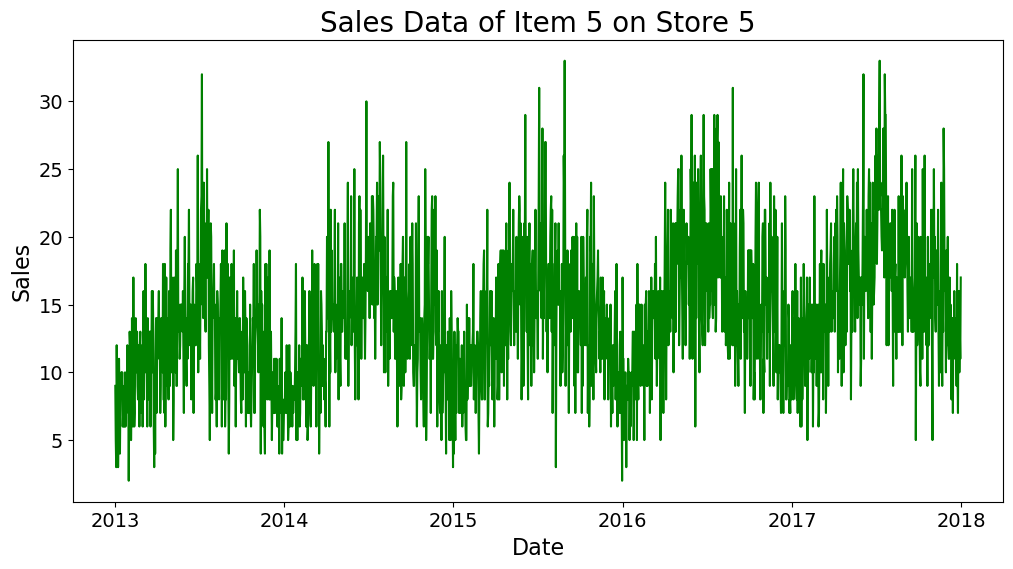

In [10]:
plot_each_item_store_sales(store_item_df,5,5)

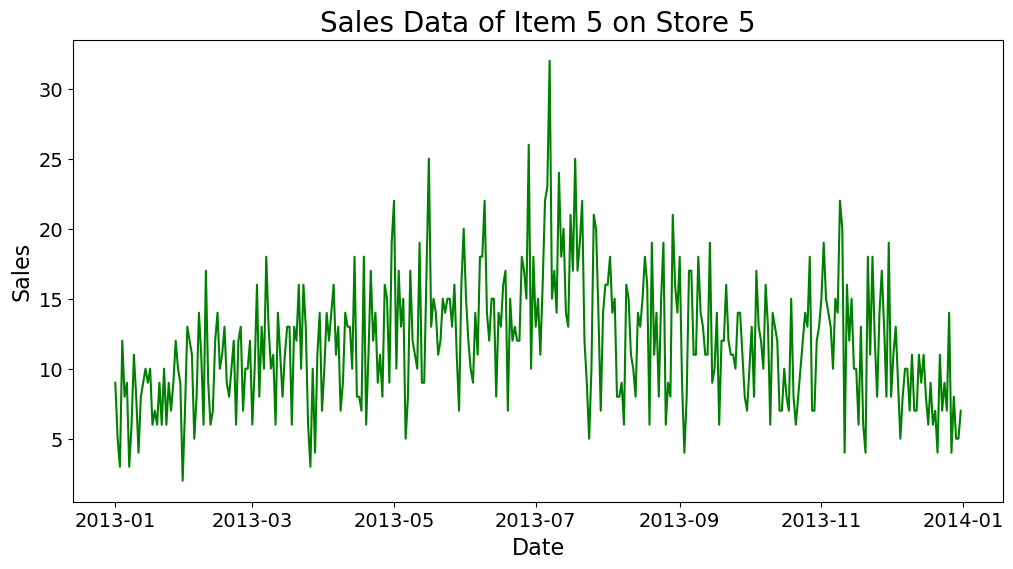

In [389]:
plot_each_item_store_sales(store_item_df.loc[store_item_df["date"]<'2014-01-01'],5,5)

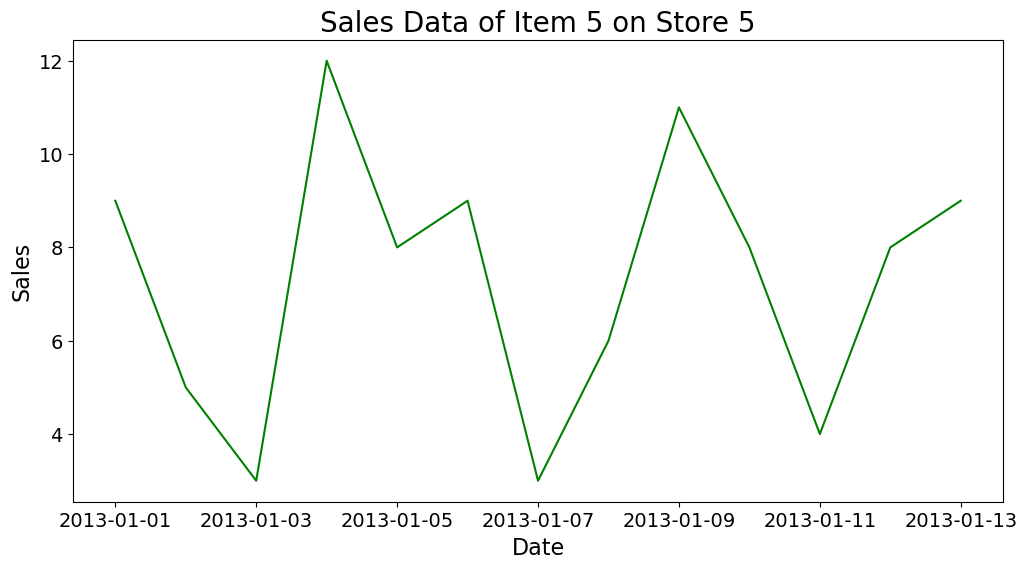

In [49]:
plot_each_item_store_sales(store_item_df.loc[store_item_df["date"]<'2013-01-14'],5,5)

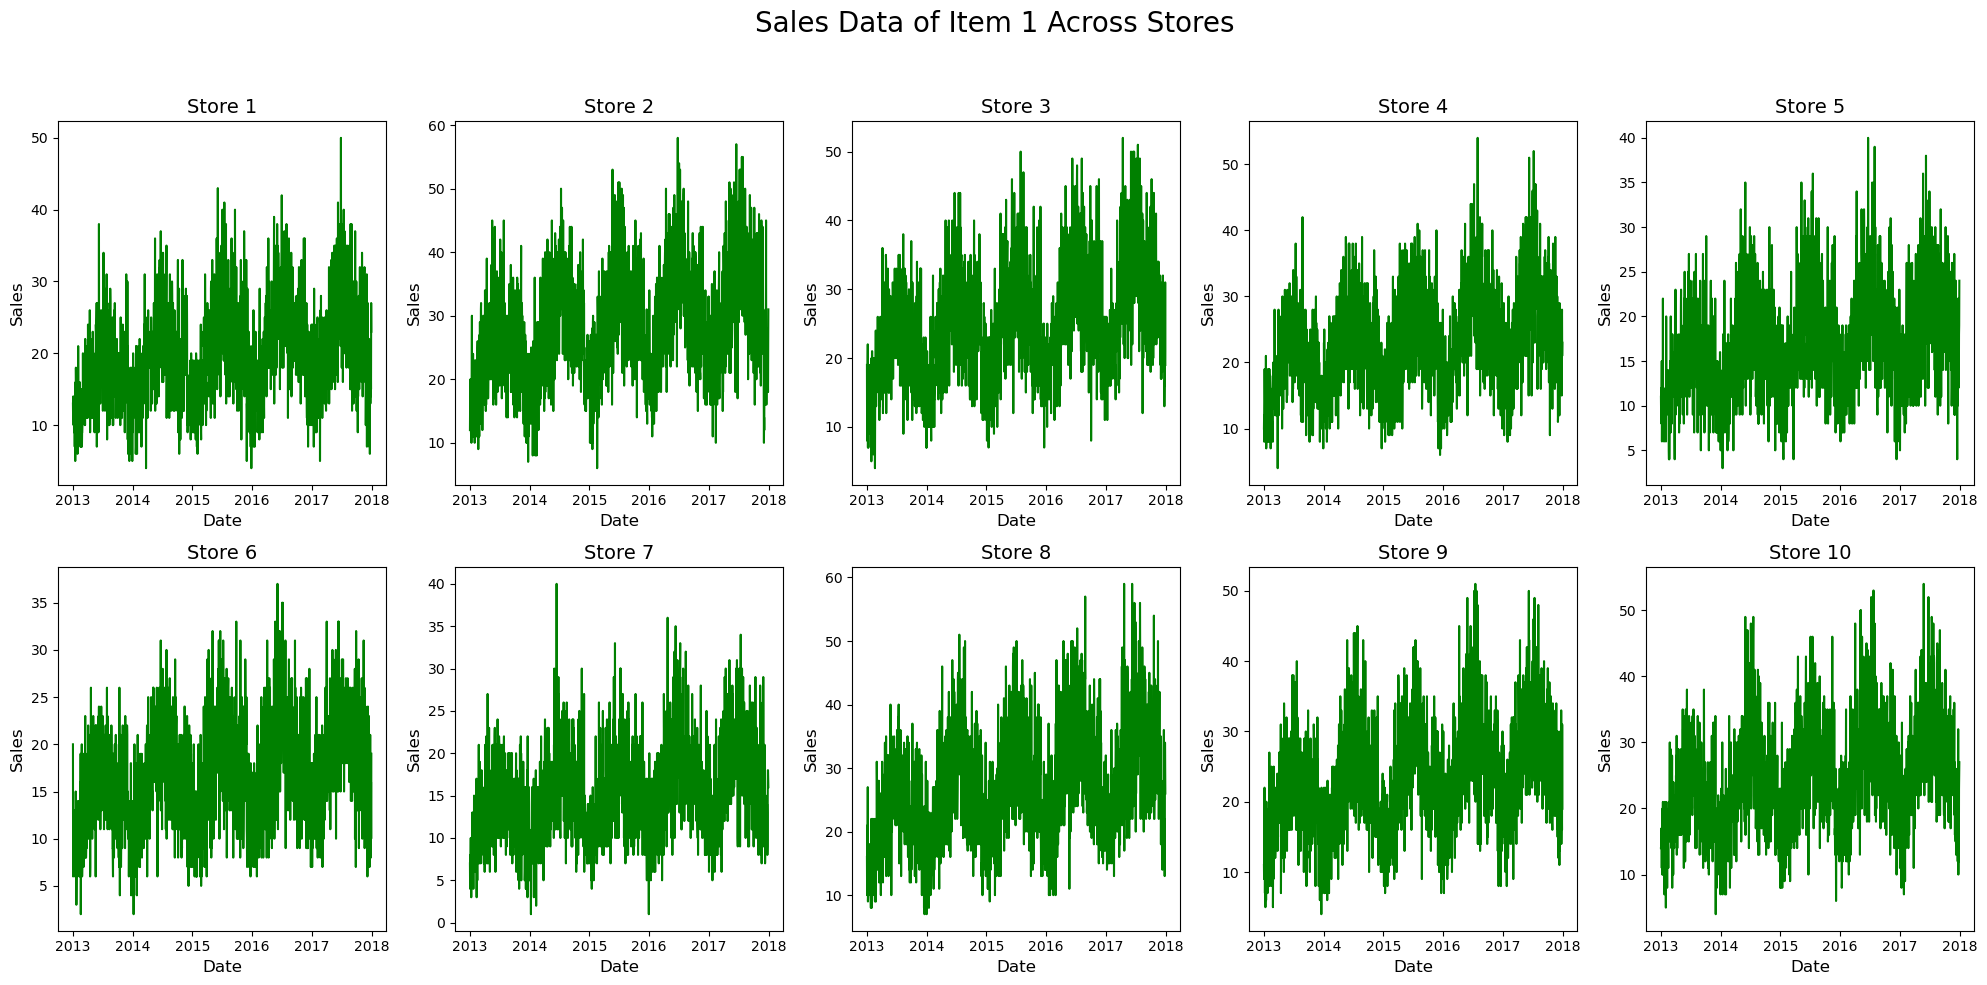

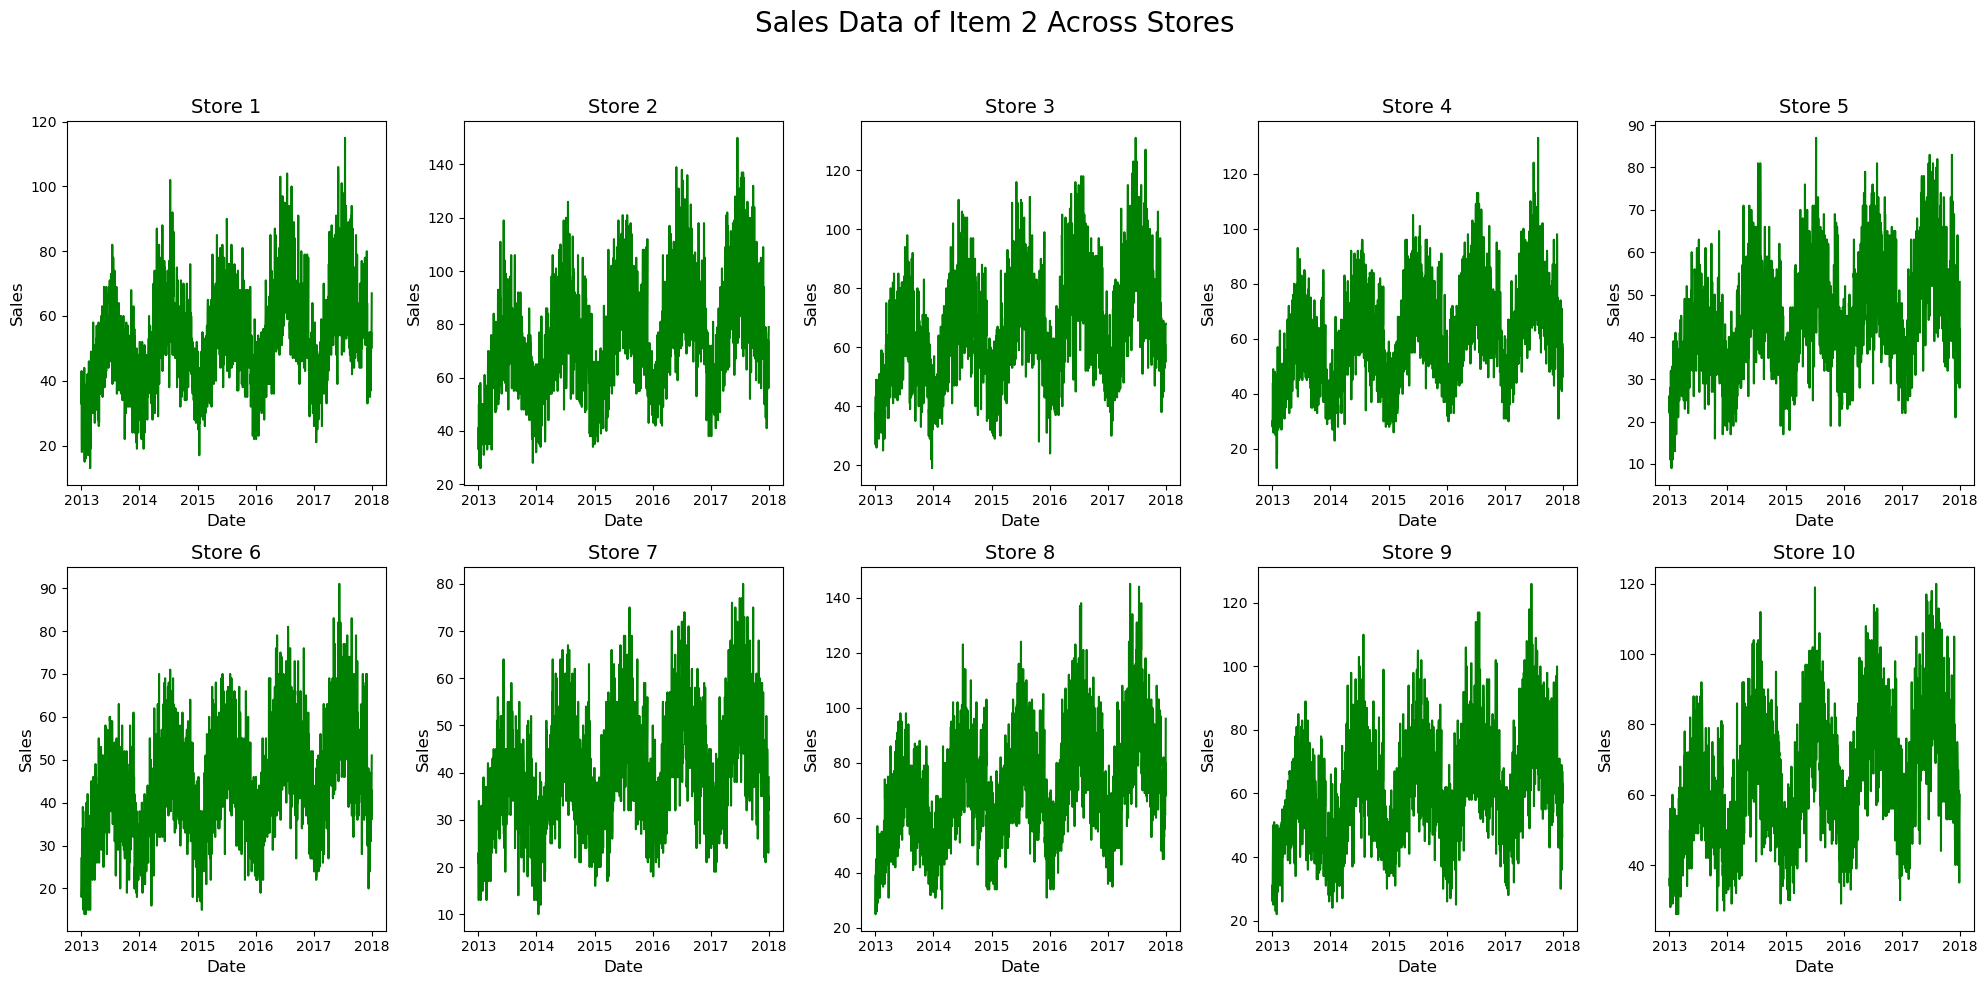

In [14]:
for i in range(1,3):
    plot_item_across_stores(store_item_df,i)

#### From Time series analysis 
The data exhibits a clear and consistent trend and seasonal patterns over time, This suggests that there is a long-term pattern of either increasing or decreasing sales.  

<br>

# Modeling

In [5]:
import numpy as np

##### Using MAE and MAPE to evalute forecasting model
MAE is defined as the average of absolute difference between forecasted values and true values.
![MAE eauation](https://www.jedox.com/wp-content/uploads/2021/07/mean-absolute-error-equation.png)

* Where y’ is forecasted value and y is the true value. 
* n is total number of values in the test set. 
* MAE tells us how big of an error we can expect from the forecast on an average^2.
* The error values are in the original units of forecasted values and MAE = 0 indicates that there is no error in the forecasted values.

MAPE is defined as the percentage of the average of absolute difference between forecasted values and true values, divided by true value.
![MAPE eauation](https://www.jedox.com/wp-content/uploads/2021/07/mean-absolute-percentage-error-equation.png)

* Where y’ is forecasted value and y is the true value. 
* n is total number of values in the test set. 

In [13]:
def evaluate_model(test_df, predict_df):
    """
    Calculates MAPE and MAE between the actual and predicted values.

    Parameters:
        train_df (DataFrame): The DataFrame containing actual values.
        predict_df (DataFrame): The DataFrame containing predicted values.

    Returns:
        mape (float): Mean Absolute Percentage Error.
        mae (float): Mean Absolute Error.
    """
    test_df.columns = ['ds','y']
    predict_df.columns = ['ds','yhat']
    
    test_df = test_df.sort_values(by='ds')
    predict_df = predict_df.sort_values(by='ds')
    
    actual = test_df['y'].values
    predicted = predict_df['yhat'].values
    
    abs_percentage_errors = np.abs((actual - predicted) / actual)
    abs_percentage_errors[actual == 0] = 0
    
    mape = 100 * np.mean(abs_percentage_errors)
    mae = np.mean(np.abs(actual - predicted))
    
    return mape, mae

In [39]:
def plot_forecasting(model_name,train_data,forecast_data,item,store):
    """
    Plots the forecasted sales data of the store and item.

    Parameters:
        model_name (String) : String represent model name
        train_data (DataFrame): The DataFrame containing training data.
        forecast_data (DataFrame): The DataFrame containing forecasted values.
        item (int): The item ID.
        store (int): The store ID.

    Returns:
        None
    """
    plt.figure(figsize=(20, 10))
    plt.title(f'({model_name}) Predict 3 months of item {item} sales on store {store} ', fontsize=30)

    train_data = train_df[(train_df['store'] == item) & (train_df['item'] == store)]
    plt.plot(train_data['date'], train_data['sales'], label='Train')

    forecast_data = test_prophet_df[(test_prophet_df['store'] == item) & (test_prophet_df['item'] == store)]
    plt.plot(forecast_data['date'], forecast_data['sales'], label='Forecast')

    plt.xlabel('Date', fontsize=15)
    plt.ylabel('Sales', fontsize=15)

    years = YearLocator()
    plt.gca().xaxis.set_major_locator(years)

    plt.show()

In [1]:
def plot_forecasting(model_name,train_data,forecast_data,item,store):
    """
    Plots the forecasted sales data of the store and item.

    Parameters:
        model_name (String) : String represent model name
        train_data (DataFrame): The DataFrame containing training data.
        forecast_data (DataFrame): The DataFrame containing forecasted values.
        item (int): The item ID.
        store (int): The store ID.

    Returns:
        None
    """
    plt.figure(figsize=(20, 10))
    plt.title(f'({model_name}) Predict 3 months of item {item} sales on store {store} ', fontsize=30)

    train_data = train_df[(train_df['store'] == item) & (train_df['item'] == store)]
    plt.plot(train_data['date'], train_data['sales'], label='Train')

    forecast_data = test_prophet_df[(test_prophet_df['store'] == item) & (test_prophet_df['item'] == store)]
    plt.plot(forecast_data['date'], forecast_data['sales'], label='Forecast')

    plt.xlabel('Date', fontsize=15)
    plt.ylabel('Sales', fontsize=15)

    years = YearLocator()
    plt.gca().xaxis.set_major_locator(years)

    plt.show()

In [10]:
# load train and test data 
test_df = pd.read_csv('demand-forecasting/test.csv')
train_df = data_df.copy()
start_date = test_df['date'].min()
end_date = test_df['date'].max()
print(f"Min date : {start_date}")
print(f"Max date : {end_date}")

Min date : 2018-01-01
Max date : 2018-03-31


In [14]:
# create evalute df
num_stores = 10
num_items_per_store = 50
data = []
for store in range(1, 11):
    for item in range(1, 51):
        data.append([store, item])

model_evaluate = pd.DataFrame(data, columns=['store', 'item'])

<br>

## Prophet Model

In [9]:
from prophet import Prophet

In [10]:
def prophet_modelling(train_set,days):
    """
    Modelling function fore prophent model

    Parameters:
        train_set (DataFrame): The DataFrame containing train values.

    Returns:
        forecast (DataFrame) : The DataFrame containing forecast values.
    """
    m = Prophet()
    m.fit(train_set)
    future = m.make_future_dataframe(periods=days)
    forecast = m.predict(future)
    return forecast

#### Data Preprocessing

In [154]:
# load train and test data
# split into train 3 year (2013-2016) and test 1 year (2017)
prophet_train_df = train_df.loc[train_df['date'] < '2017-01-01']
prophet_test_df = train_df.loc[train_df['date'] >= '2017-01-01'].reset_index(drop=True)

In [155]:
# makeing evalute df for prophet
model_evaluate['Prophet_MAPE'] = 0
model_evaluate['Prophet_MAE'] = 0

# makeing test df for prophet 
test_prophet_df = test_df.copy()

#### Training and Forecasting model

In [2]:
# loop across item and store to forecast and make an model and evalute it
forecast_2018_list = []
for store in range(1, 10+1):
    for item in range(1, 50+1):
        train = prophet_train_df.loc[(prophet_train_df['store']==store) & (prophet_train_df['item']==item), ['date', 'sales']]
        test = prophet_test_df.loc[(prophet_test_df['store']==store) & (prophet_test_df['item']==item), ['date', 'sales']]

        # Change format variable name 
        train.columns = ['ds','y']
        test.columns = ['ds','y']

        forecast = prophet_modelling(train, days=365+90)
        
        # Train and Test
        predict_df = forecast.loc[(forecast['ds'] >= '2017-01-01')&(forecast['ds'] < '2018-01-01'), ['ds','yhat']].reset_index(drop=True)
        mape, mae = evaluate_model(test, predict_df)
        model_evaluate.loc[(model_evaluate['store']==store) & (model_evaluate['item']==item), 'Prophet_MAPE'] = mape
        model_evaluate.loc[(model_evaluate['store']==store) & (model_evaluate['item']==item), 'Prophet_MAE'] = mae
        
        # Forecast next year 2018
        predict_2018_df = forecast.loc[forecast['ds'] >= '2018-01-01', ['ds','yhat']].reset_index(drop=True)
        forecast_2018_list.append(predict_2018_df['yhat'])
        
        print(f"Complete Store : {store} ,Item : {item}")

NameError: name 'prophet_train_df' is not defined

#### Evaluate Prophet model 

In [160]:
model_evaluate

,store,item,Prophet_MAPE,Prophet_MAE
0,1,1,22.257316,4.034702
1,1,2,14.283157,7.538167
2,1,3,15.541290,5.167513
3,1,4,21.352905,3.994063
4,1,5,23.733387,3.475651
...,...,...,...,...
495,10,46,14.110710,9.051198
496,10,47,19.429605,4.782635
497,10,48,12.296158,7.348726
498,10,49,16.908306,5.325499


In [164]:
model_evaluate.to_csv("results\prophet\model_evaluate_prophet.csv")

#### Save Prophet model forecasting results

In [162]:
test_prophet_df['sales'] = pd.concat(forecast_2018_list, ignore_index=True)
test_prophet_df

,id,date,store,item,sales
0,0,2018-01-01,1,1,14.676155
1,1,2018-01-02,1,1,17.304778
2,2,2018-01-03,1,1,17.840722
3,3,2018-01-04,1,1,18.245526
4,4,2018-01-05,1,1,20.123513
...,...,...,...,...,...
44995,44995,2018-03-27,10,50,84.668806
44996,44996,2018-03-28,10,50,85.690816
44997,44997,2018-03-29,10,50,90.458933
44998,44998,2018-03-30,10,50,95.370310


In [163]:
test_prophet_df.to_csv("results\prophet\prophet_forecasting.csv")

#### Model results

Mean Prophet MAPE: 14.382285961467653
Mean Prophet MAE: 6.794507966150583


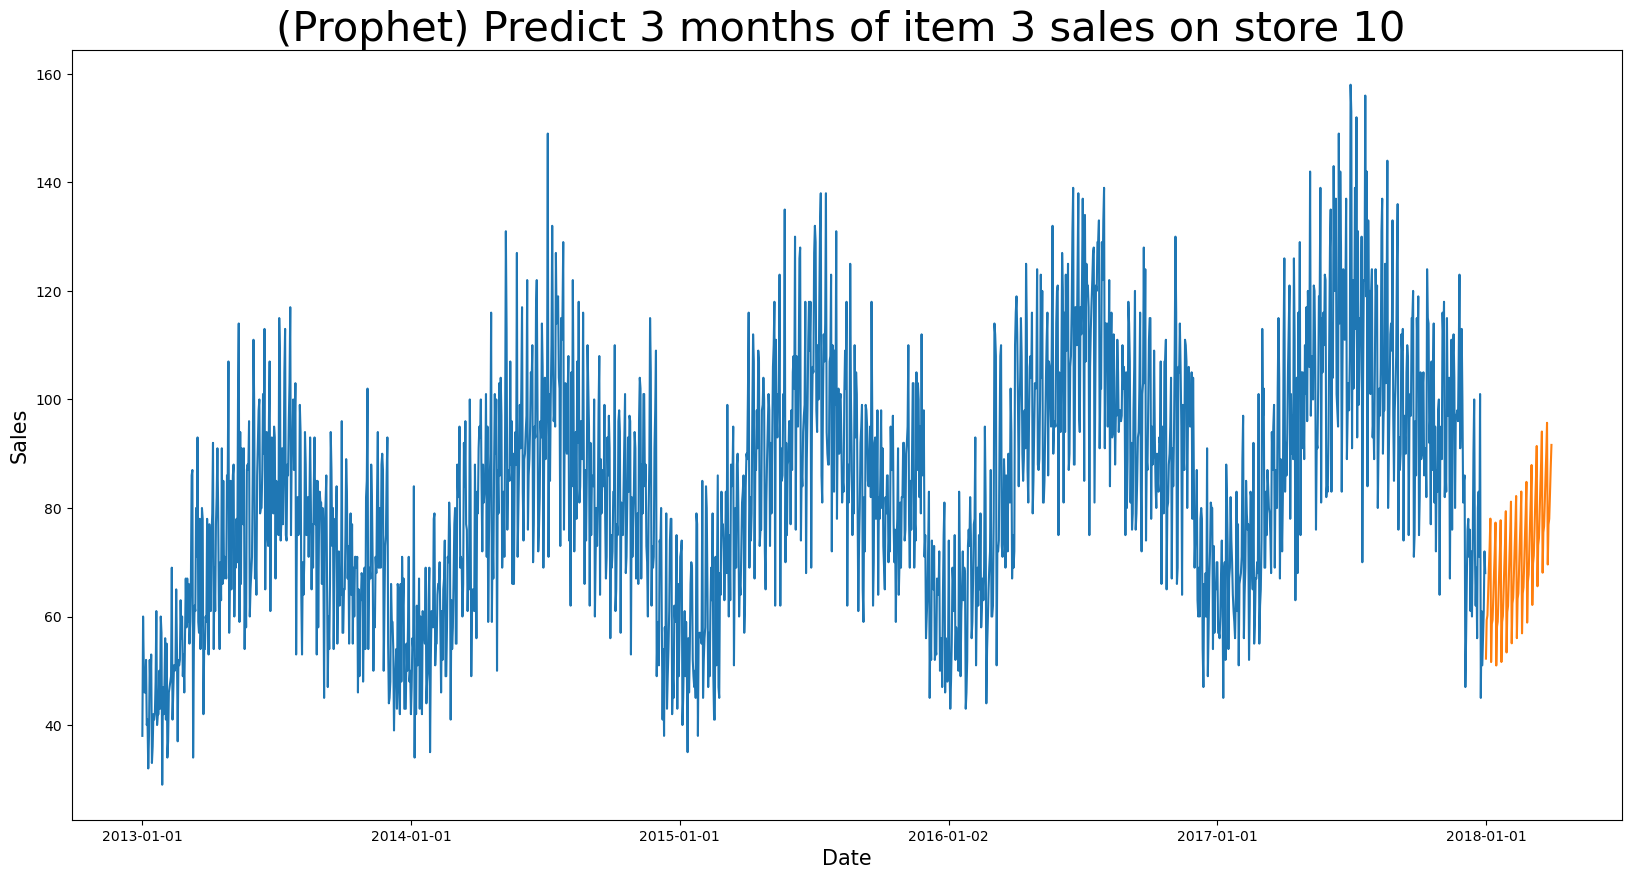

In [40]:
print(f"Mean Prophet MAPE: {model_evaluate['Prophet_MAPE'].mean()}")
print(f"Mean Prophet MAE: {model_evaluate['Prophet_MAE'].mean()}")
plot_forecasting("Prophet",train_df,test_prophet_df,3,10)

<br>

## ARIMA model

In [9]:
from pmdarima import auto_arima

#### Data Preprocessing

In [353]:
# load train and test data
# split into train 3 year (2013-2016) and test 1 year (2017)
arima_train_df = train_df.loc[train_df['date'] < '2017-01-01']
arima_test_df = train_df.loc[train_df['date'] >= '2017-01-01'].reset_index(drop=True)

In [355]:
# makeing evalute df for arima
model_evaluate['ARIMA_MAPE'] = 0
model_evaluate['ARIMA_MAE'] = 0

# makeing test df for arima 
test_arima_df = test_df.copy()

#### Training and Forecasting model

In [356]:
# loop across item and store to forecast and make an model and evalute it
forecast_2018_list = []
for store in range(1, 10+1):
    for item in range(1, 50+1):
        # training set
        train = arima_train_df.loc[(arima_train_df['store']==store) & (arima_train_df['item']==item), ['date', 'sales']]
        train['date'] = pd.to_datetime(train['date']) 
        train = train.set_index('date')
        train.index.freq = 'D'
        
        test = arima_test_df.loc[(arima_test_df['store']==store) & (arima_test_df['item']==item), ['date', 'sales']]

        arima_model = auto_arima(train,
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
        arima_model.fit(train)
        predict = arima_model.predict(n_periods=365+90)
        
        # Turn predict into forecast dataframe
        forecast = pd.DataFrame({'date': predict.index, 'sales': predict.values})
        forecast['date'] = pd.to_datetime(forecast['date'])
        
        # Train and Test
        predict_df = forecast.loc[(forecast['date'] >= '2017-01-01')&(forecast['date'] < '2018-01-01'), ['date','sales']].reset_index(drop=True)
        mape, mae = evaluate_model(test, predict_df)
        model_evaluate.loc[(model_evaluate['store']==store) & (model_evaluate['item']==item), 'ARIMA_MAPE'] = mape
        model_evaluate.loc[(model_evaluate['store']==store) & (model_evaluate['item']==item), 'ARIMA_MAE'] = mae
        
        # Forecast next year 2018
        predict_2018_df = forecast.loc[forecast['date'] >= '2018-01-01', ['date','sales']].reset_index(drop=True)
        forecast_2018_list.append(predict_2018_df['sales'])
        
        print(f"Complete Store : {store} ,Item : {item}")

Complete Store : 1 ,Item : 1
Complete Store : 1 ,Item : 2
Complete Store : 1 ,Item : 3
Complete Store : 1 ,Item : 4
Complete Store : 1 ,Item : 5
Complete Store : 1 ,Item : 6
Complete Store : 1 ,Item : 7
Complete Store : 1 ,Item : 8
Complete Store : 1 ,Item : 9
Complete Store : 1 ,Item : 10
Complete Store : 1 ,Item : 11
Complete Store : 1 ,Item : 12
Complete Store : 1 ,Item : 13
Complete Store : 1 ,Item : 14
Complete Store : 1 ,Item : 15
Complete Store : 1 ,Item : 16
Complete Store : 1 ,Item : 17
Complete Store : 1 ,Item : 18
Complete Store : 1 ,Item : 19
Complete Store : 1 ,Item : 20
Complete Store : 1 ,Item : 21
Complete Store : 1 ,Item : 22
Complete Store : 1 ,Item : 23
Complete Store : 1 ,Item : 24
Complete Store : 1 ,Item : 25
Complete Store : 1 ,Item : 26
Complete Store : 1 ,Item : 27
Complete Store : 1 ,Item : 28
Complete Store : 1 ,Item : 29
Complete Store : 1 ,Item : 30
Complete Store : 1 ,Item : 31
Complete Store : 1 ,Item : 32
Complete Store : 1 ,Item : 33
Complete Store : 1 

Complete Store : 6 ,Item : 26
Complete Store : 6 ,Item : 27
Complete Store : 6 ,Item : 28
Complete Store : 6 ,Item : 29
Complete Store : 6 ,Item : 30
Complete Store : 6 ,Item : 31
Complete Store : 6 ,Item : 32
Complete Store : 6 ,Item : 33
Complete Store : 6 ,Item : 34
Complete Store : 6 ,Item : 35
Complete Store : 6 ,Item : 36
Complete Store : 6 ,Item : 37
Complete Store : 6 ,Item : 38
Complete Store : 6 ,Item : 39
Complete Store : 6 ,Item : 40
Complete Store : 6 ,Item : 41
Complete Store : 6 ,Item : 42
Complete Store : 6 ,Item : 43
Complete Store : 6 ,Item : 44
Complete Store : 6 ,Item : 45
Complete Store : 6 ,Item : 46
Complete Store : 6 ,Item : 47
Complete Store : 6 ,Item : 48
Complete Store : 6 ,Item : 49
Complete Store : 6 ,Item : 50
Complete Store : 7 ,Item : 1
Complete Store : 7 ,Item : 2
Complete Store : 7 ,Item : 3
Complete Store : 7 ,Item : 4
Complete Store : 7 ,Item : 5
Complete Store : 7 ,Item : 6
Complete Store : 7 ,Item : 7
Complete Store : 7 ,Item : 8
Complete Store : 7

#### Evaluate ARIMA model 

In [362]:
model_evaluate

,Unnamed: 0,store,item,Prophet_MAPE,Prophet_MAE,ARIMA_MAPE,ARIMA_MAE
0,0,1,1,22.257316,4.034702,28.311257,6.321634
1,1,1,2,14.283157,7.538167,25.326067,16.576210
2,2,1,3,15.541290,5.167513,25.304152,10.081240
3,3,1,4,21.352905,3.994063,26.308700,5.981913
4,4,1,5,23.733387,3.475651,29.539224,5.447740
...,...,...,...,...,...,...,...
495,495,10,46,14.110710,9.051198,24.060009,19.032515
496,496,10,47,19.429605,4.782635,26.941934,7.812983
497,497,10,48,12.296158,7.348726,27.755980,19.863837
498,498,10,49,16.908306,5.325499,26.911864,10.234744


In [23]:
model_evaluate.to_csv(r"results\arima\model_evaluate_arima.csv")

#### Save ARIMA model forecasting results

In [368]:
test_arima_df['sales'] = pd.concat(forecast_2018_list, ignore_index=True)
test_arima_df

,id,date,store,item,sales
0,0,2018-01-01,1,1,18.368082
1,1,2018-01-02,1,1,18.368891
2,2,2018-01-03,1,1,18.369694
3,3,2018-01-04,1,1,18.370493
4,4,2018-01-05,1,1,18.371286
...,...,...,...,...,...
44995,44995,2018-03-27,10,50,57.627953
44996,44996,2018-03-28,10,50,57.487176
44997,44997,2018-03-29,10,50,59.333054
44998,44998,2018-03-30,10,50,61.771505


In [370]:
test_arima_df.to_csv(r"results\arima\arima_forecasting.csv")

#### Model results

Mean ARIMA MAPE: 27.54320193535548
Mean ARIMA MAE: 17.499798628003504


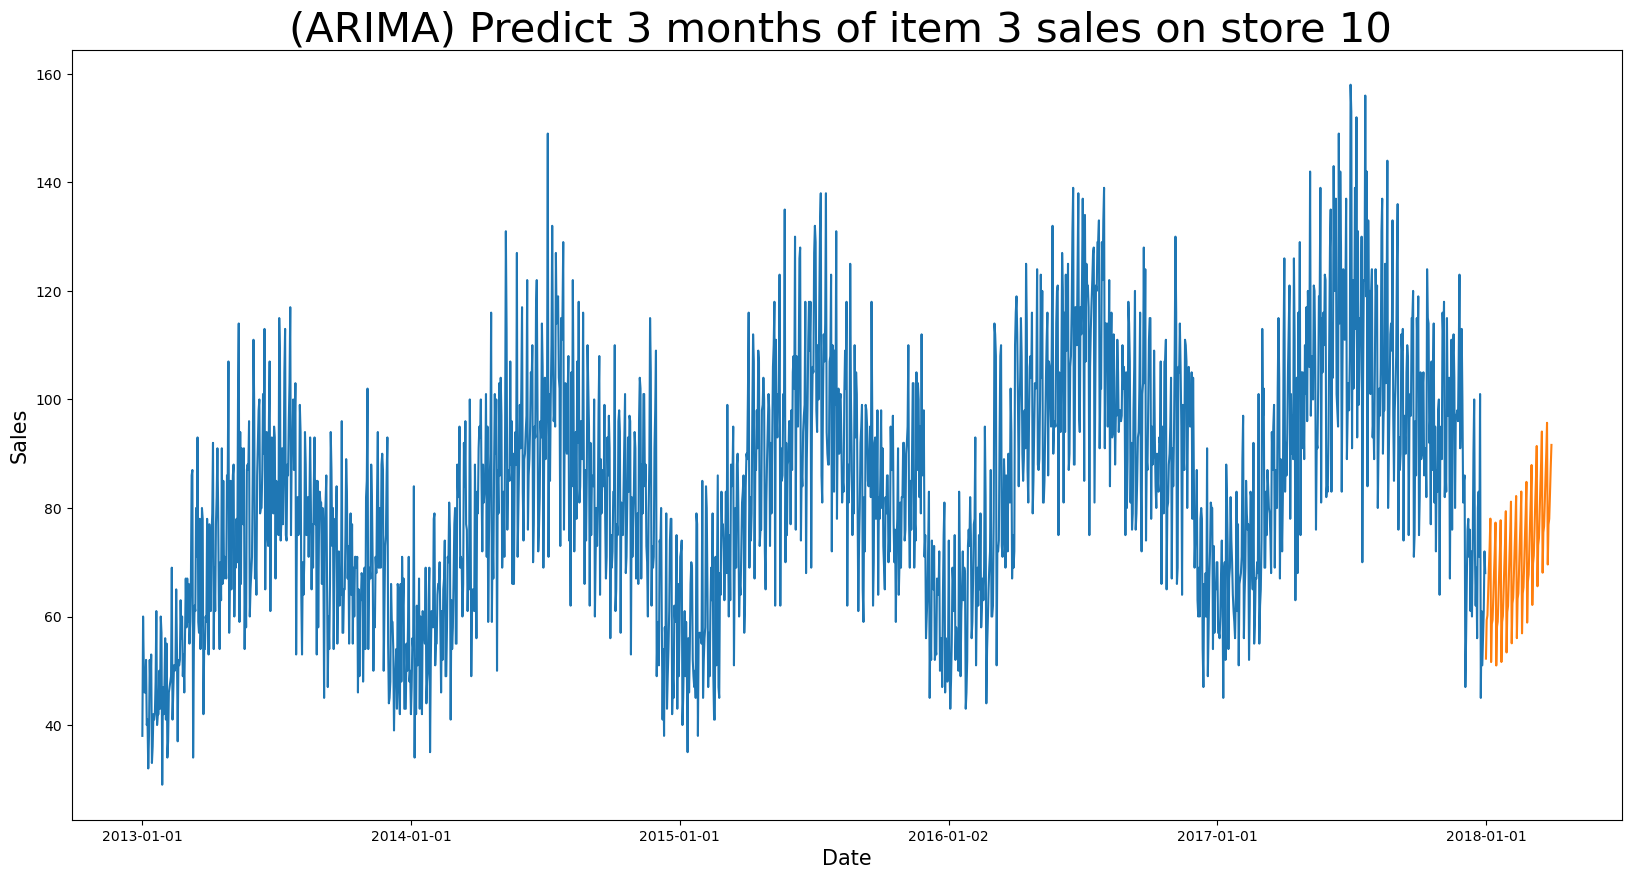

In [41]:
print(f"Mean ARIMA MAPE: {model_evaluate['ARIMA_MAPE'].mean()}")
print(f"Mean ARIMA MAE: {model_evaluate['ARIMA_MAE'].mean()}")
plot_forecasting("ARIMA",train_df,test_arima_df,3,10)

<br>

<br>

## SARIMAX Model

#### Data Preprocessing

In [13]:
# load train and test data
# split into train 3 year (2013-2016) and test 1 year (2017)
sarimax_train_df = train_df.loc[train_df['date'] < '2017-01-01']
sarimax_test_df = train_df.loc[train_df['date'] >= '2017-01-01'].reset_index(drop=True)

In [16]:
# made exogenous data
sarimax_train_df.loc[:, 'month'] = pd.to_datetime(sarimax_train_df['date']).dt.month
sarimax_train_df

,date,store,item,sales,month
0,2013-01-01,1,1,13,1
1,2013-01-02,1,1,11,1
2,2013-01-03,1,1,14,1
3,2013-01-04,1,1,13,1
4,2013-01-05,1,1,10,1
...,...,...,...,...,...
912630,2016-12-27,10,50,60,12
912631,2016-12-28,10,50,43,12
912632,2016-12-29,10,50,68,12
912633,2016-12-30,10,50,63,12


In [17]:
# makeing evalute df for sarima
model_evaluate['SARIMAX_MAPE'] = 0
model_evaluate['SARIMAX_MAE'] = 0

# makeing test df for sarima 
test_sarimax_df = test_df.copy()

#### Training and Forecasting model

In [29]:
%%time
# loop across item and store to forecast and make an model and evalute it
forecast_2018_list = []
for store in range(1, 10+1):
    for item in range(1, 50+1):
        # training set
        train = sarimax_train_df.loc[(sarimax_train_df['store']==store) & (sarimax_train_df['item']==item), ['date', 'sales']]
        train['date'] = pd.to_datetime(train['date']) 
        train = train.set_index('date')
        train.index.freq = 'D'
        
        test = sarimax_test_df.loc[(sarimax_test_df['store']==store) & (sarimax_test_df['item']==item), ['date', 'sales']]

        sarimax_model = auto_arima(train, exogenous=sarimax_train_df[['month']] ,
                           start_p=1, 
                           start_q=1,
                           test='adf',
                           max_p=3, max_q=3, 
                           m=7,
                           start_P=0, seasonal=True,
                           d=None, D=1, 
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
        sarimax_model.fit(train)
        
        
        predict = sarimax_model.predict(n_periods=365+90)
        
        # Turn predict into forecast dataframe
        forecast = pd.DataFrame({'date': predict.index, 'sales': predict.values})
        forecast['date'] = pd.to_datetime(forecast['date'])
        
        # Train and Test
        predict_df = forecast.loc[(forecast['date'] >= '2017-01-01')&(forecast['date'] < '2018-01-01'), ['date','sales']].reset_index(drop=True)
        mape, mae = evaluate_model(test, predict_df)
        model_evaluate.loc[(model_evaluate['store']==store) & (model_evaluate['item']==item), 'SARIMAX_MAPE'] = mape
        model_evaluate.loc[(model_evaluate['store']==store) & (model_evaluate['item']==item), 'SARIMAX_MAE'] = mae
        
        # Forecast next year 2018
        predict_2018_df = forecast.loc[forecast['date'] >= '2018-01-01', ['date','sales']].reset_index(drop=True)
        forecast_2018_list.append(predict_2018_df['sales'])
        
        print(f"Complete Store : {store} ,Item : {item}")

Complete Store : 1 ,Item : 1
Complete Store : 1 ,Item : 2
Complete Store : 1 ,Item : 3
Complete Store : 1 ,Item : 4
Complete Store : 1 ,Item : 5
Complete Store : 1 ,Item : 6
Complete Store : 1 ,Item : 7
Complete Store : 1 ,Item : 8
Complete Store : 1 ,Item : 9
Complete Store : 1 ,Item : 10
Complete Store : 1 ,Item : 11
Complete Store : 1 ,Item : 12
Complete Store : 1 ,Item : 13
Complete Store : 1 ,Item : 14
Complete Store : 1 ,Item : 15
Complete Store : 1 ,Item : 16
Complete Store : 1 ,Item : 17
Complete Store : 1 ,Item : 18
Complete Store : 1 ,Item : 19
Complete Store : 1 ,Item : 20
Complete Store : 1 ,Item : 21
Complete Store : 1 ,Item : 22
Complete Store : 1 ,Item : 23
Complete Store : 1 ,Item : 24
Complete Store : 1 ,Item : 25
Complete Store : 1 ,Item : 26
Complete Store : 1 ,Item : 27
Complete Store : 1 ,Item : 28
Complete Store : 1 ,Item : 29
Complete Store : 1 ,Item : 30
Complete Store : 1 ,Item : 31
Complete Store : 1 ,Item : 32
Complete Store : 1 ,Item : 33
Complete Store : 1 

Complete Store : 6 ,Item : 26
Complete Store : 6 ,Item : 27
Complete Store : 6 ,Item : 28
Complete Store : 6 ,Item : 29
Complete Store : 6 ,Item : 30
Complete Store : 6 ,Item : 31
Complete Store : 6 ,Item : 32
Complete Store : 6 ,Item : 33
Complete Store : 6 ,Item : 34
Complete Store : 6 ,Item : 35
Complete Store : 6 ,Item : 36
Complete Store : 6 ,Item : 37
Complete Store : 6 ,Item : 38
Complete Store : 6 ,Item : 39
Complete Store : 6 ,Item : 40
Complete Store : 6 ,Item : 41
Complete Store : 6 ,Item : 42
Complete Store : 6 ,Item : 43
Complete Store : 6 ,Item : 44
Complete Store : 6 ,Item : 45
Complete Store : 6 ,Item : 46
Complete Store : 6 ,Item : 47
Complete Store : 6 ,Item : 48
Complete Store : 6 ,Item : 49
Complete Store : 6 ,Item : 50
Complete Store : 7 ,Item : 1
Complete Store : 7 ,Item : 2
Complete Store : 7 ,Item : 3
Complete Store : 7 ,Item : 4
Complete Store : 7 ,Item : 5
Complete Store : 7 ,Item : 6
Complete Store : 7 ,Item : 7
Complete Store : 7 ,Item : 8
Complete Store : 7

#### Evaluate SARIMAX model 

In [30]:
model_evaluate

,store,item,Prophet_MAPE,Prophet_MAE,ARIMA_MAPE,ARIMA_MAE,SARIMAX_MAPE,SARIMAX_MAE
0,1,1,22.257316,4.034702,28.311257,6.321634,26.769822,5.988632
1,1,2,14.283157,7.538167,25.326067,16.576210,25.082006,16.236620
2,1,3,15.541290,5.167513,25.304152,10.081240,25.681989,10.208469
3,1,4,21.352905,3.994063,26.308700,5.981913,26.367829,5.855894
4,1,5,23.733387,3.475651,29.539224,5.447740,26.860899,4.777099
...,...,...,...,...,...,...,...,...
495,10,46,14.110710,9.051198,24.060009,19.032515,22.614295,17.819930
496,10,47,19.429605,4.782635,26.941934,7.812983,30.014592,8.766823
497,10,48,12.296158,7.348726,27.755980,19.863837,25.524509,17.826832
498,10,49,16.908306,5.325499,26.911864,10.234744,27.513123,10.529131


In [31]:
model_evaluate.to_csv(r"results\sarimax\model_evaluate_sarimax.csv")

#### Save SARIMAX model forecasting results

In [32]:
test_sarimax_df['sales'] = pd.concat(forecast_2018_list, ignore_index=True)
test_sarimax_df

,id,date,store,item,sales
0,0,2018-01-01,1,1,16.212683
1,1,2018-01-02,1,1,17.023899
2,2,2018-01-03,1,1,16.213636
3,3,2018-01-04,1,1,17.985673
4,4,2018-01-05,1,1,19.311136
...,...,...,...,...,...
44995,44995,2018-03-27,10,50,63.403056
44996,44996,2018-03-28,10,50,54.779120
44997,44997,2018-03-29,10,50,63.977744
44998,44998,2018-03-30,10,50,68.119743


In [33]:
test_sarimax_df.to_csv(r"results\sarimax\sarimax_forecasting.csv")

#### Model results

Mean SARIMAX MAPE: 26.07217243038132
Mean SARIMAX MAE: 16.36081236626218


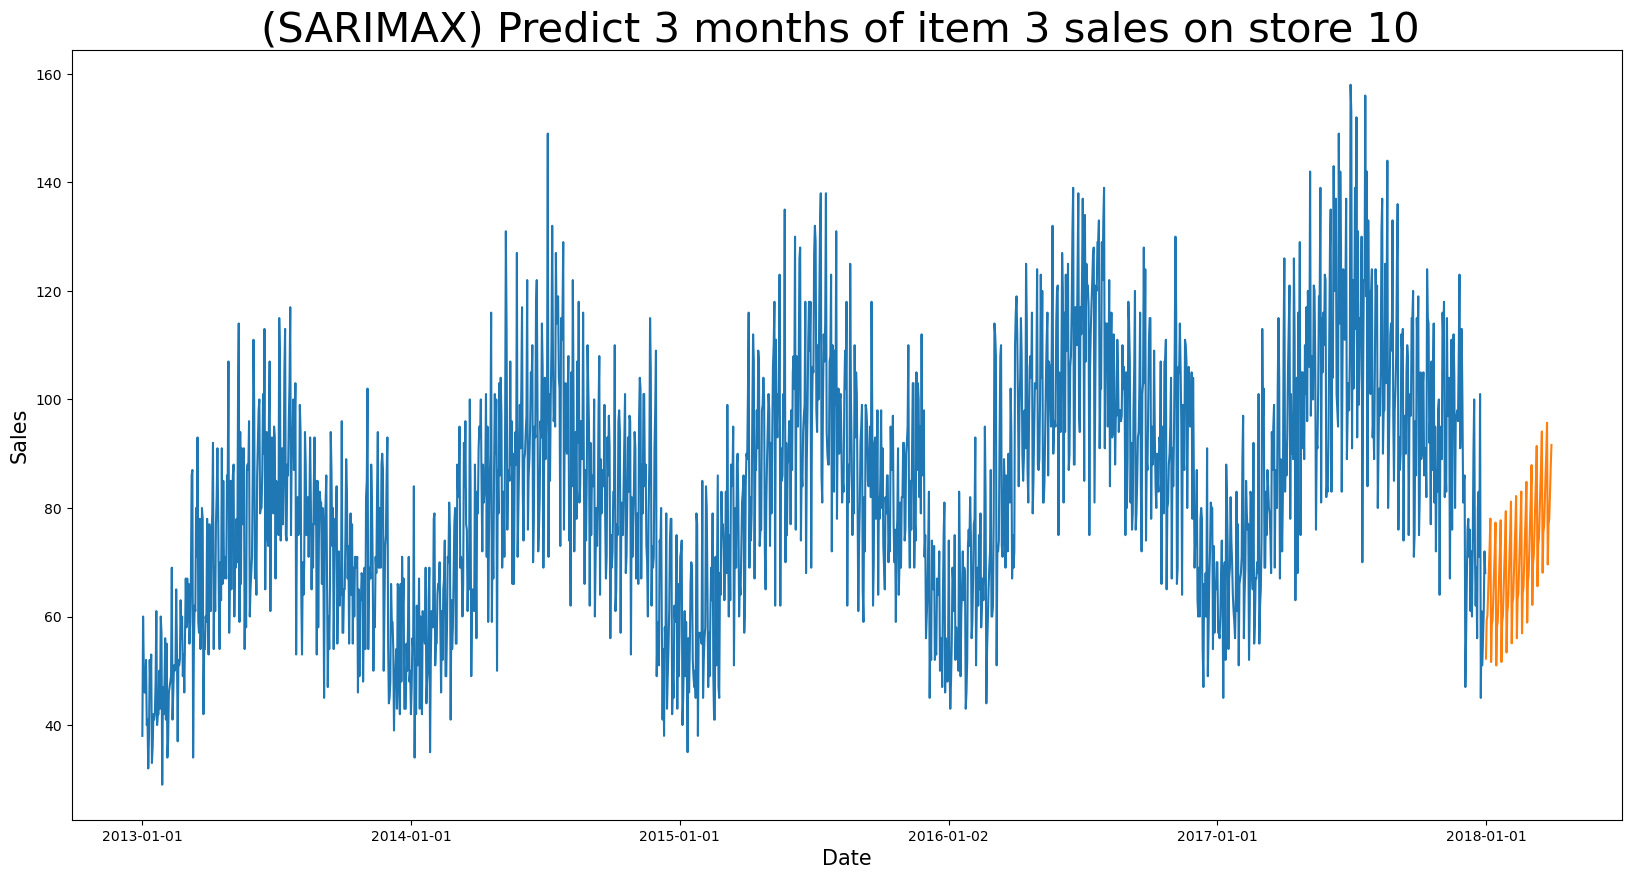

In [42]:
print(f"Mean SARIMAX MAPE: {model_evaluate['SARIMAX_MAPE'].mean()}")
print(f"Mean SARIMAX MAE: {model_evaluate['SARIMAX_MAE'].mean()}")
plot_forecasting("SARIMAX",train_df,test_sarimax_df,3,10)

<br>

## Model Experimental Results

In [18]:
model_evaluate

,store,item,Prophet_MAPE,Prophet_MAE,ARIMA_MAPE,ARIMA_MAE,SARIMAX_MAPE,SARIMAX_MAE
0,1,1,22.257316,4.034702,28.311257,6.321634,26.769822,5.988632
1,1,2,14.283157,7.538167,25.326067,16.576210,25.082006,16.236620
2,1,3,15.541290,5.167513,25.304152,10.081240,25.681989,10.208469
3,1,4,21.352905,3.994063,26.308700,5.981913,26.367829,5.855894
4,1,5,23.733387,3.475651,29.539224,5.447740,26.860899,4.777099
...,...,...,...,...,...,...,...,...
495,10,46,14.110710,9.051198,24.060009,19.032515,22.614295,17.819930
496,10,47,19.429605,4.782635,26.941934,7.812983,30.014592,8.766823
497,10,48,12.296158,7.348726,27.755980,19.863837,25.524509,17.826832
498,10,49,16.908306,5.325499,26.911864,10.234744,27.513123,10.529131


In [45]:
evaluate_df = pd.DataFrame()
evaluate_df.loc["Prophet","MAPE"] = model_evaluate["Prophet_MAPE"].mean()
evaluate_df.loc["Prophet","MAE"] =model_evaluate["Prophet_MAE"].mean()
evaluate_df.loc["Arima","MAPE"] =model_evaluate["ARIMA_MAPE"].mean()
evaluate_df.loc["Arima","MAE"] =model_evaluate["ARIMA_MAE"].mean()
evaluate_df.loc["Sarimax","MAPE"] =model_evaluate["SARIMAX_MAPE"].mean()
evaluate_df.loc["Sarimax","MAE"] =model_evaluate["SARIMAX_MAE"].mean()
evaluate_df

,MAPE,MAE
Prophet,14.382286,6.794508
Arima,27.543202,17.499799
Sarimax,26.072172,16.360812


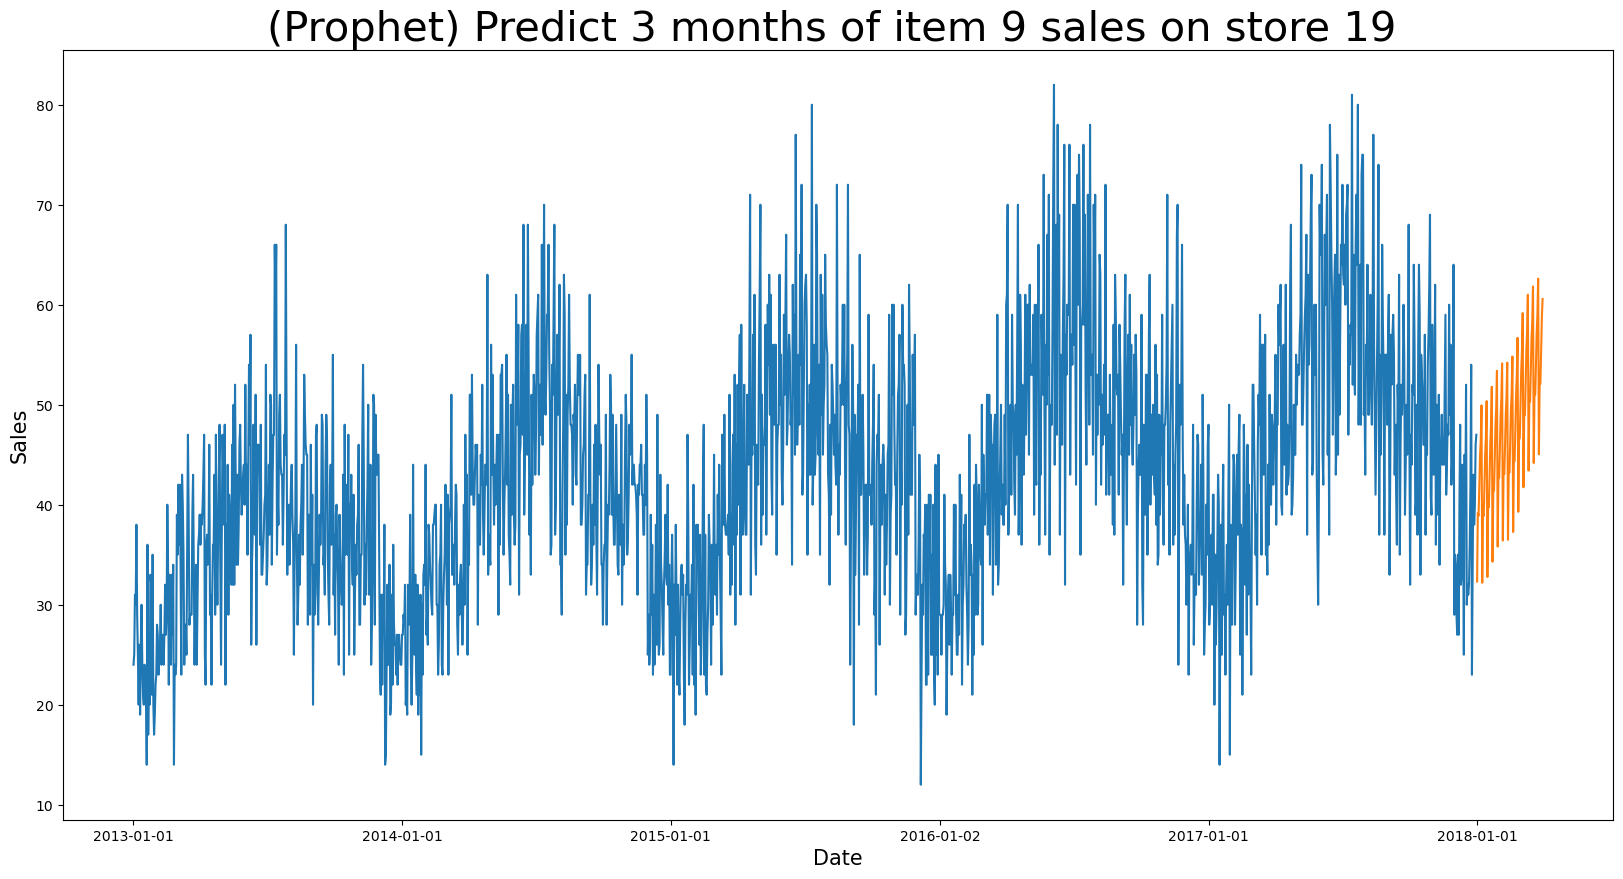

In [44]:
plot_forecasting("Prophet",train_df,test_prophet_df,9,19)

### Conclusion
The best performing model is Prophet, which achieved a Mean Absolute Percentage Error (MAPE) of 14.38% and a Mean Absolute Error (MAE) of 6.79.